# Imports & Config

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from matplotlib.colors import ListedColormap
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

# Seaborn Config
# Define the palette
plt.rcParams['font.family'] = 'Helvetica'  # If available
# If Helvetica is not installed, you can use DejaVu Sans or another sans-serif
# plt.rcParams['font.family'] = 'DejaVu Sans'

# Base Seaborn style
custom_palette = ['#FF0000', '#00AEEF', '#F4A731', '#F2DC00', '#BDD731', '#8B7765', '#67727B']
custom_cmap = ListedColormap(custom_palette)

sns.set_theme(
    style='whitegrid',   # or 'white', 'darkgrid', etc.
    context='notebook',  # 'notebook' is default; alternatives: 'talk', 'poster', 'paper'
    palette=sns.color_palette(custom_palette)
)

# Fine-tune fonts and spacing
plt.rcParams.update({
    'axes.titlesize': 14,
    'axes.labelsize': 12,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 10,
    'figure.titlesize': 16,
    'axes.titleweight': 'bold',
    'axes.labelweight': 'regular',
    'figure.dpi': 100,
    'savefig.dpi': 300
})

In [2]:
def evaluate_model(y_test=None, y_pred=None, title=None):
    """
    Evaluate the model's accuracy and print classification report.
    """
    print(f"\n{title} Evaluation:")
    accuracy = accuracy_score(y_test, y_pred)
    print(f'Accuracy score: {accuracy}')
    print(f'Accuracy [%]: {accuracy:.2f}')
    print(classification_report(y_test, y_pred))

# Data Loading: Logistic Regression Example

In [3]:
# Generate the data
X, y = make_classification(
    n_samples=1000,       # number of samples
    n_features=5,         # total features
    n_informative=3,      # informative features (that impact y)
    n_redundant=0,        # no redundant features
    n_repeated=0,         # no repeated features
    n_classes=2,          # binary classification (0 or 1)
    random_state=42,      # reproducibility
    flip_y=0.05,          # 5% label noise
    class_sep=0.8         # 1 is default; 1.5 would make classes more separable
)

# Convert to DataFrame for easier handling
df = pd.DataFrame(X, columns=[f'feature_{i}' for i in range(1, 6)])
df['target'] = y

df.head()

,feature_1,feature_2,feature_3,feature_4,feature_5,target
0,1.388740,0.210986,1.272570,0.510157,0.307752,1
1,1.573719,1.848157,0.734638,0.692856,-0.640768,1
2,-1.984518,-1.334134,1.386349,1.153590,0.239843,0
3,-0.178737,-0.305080,-0.217131,0.990166,-0.988438,0
4,0.736019,0.100185,0.739653,-0.139397,-0.924700,0


In [4]:
X.shape, y.shape

((1000, 5), (1000,))

# Step 1: Data Understanding

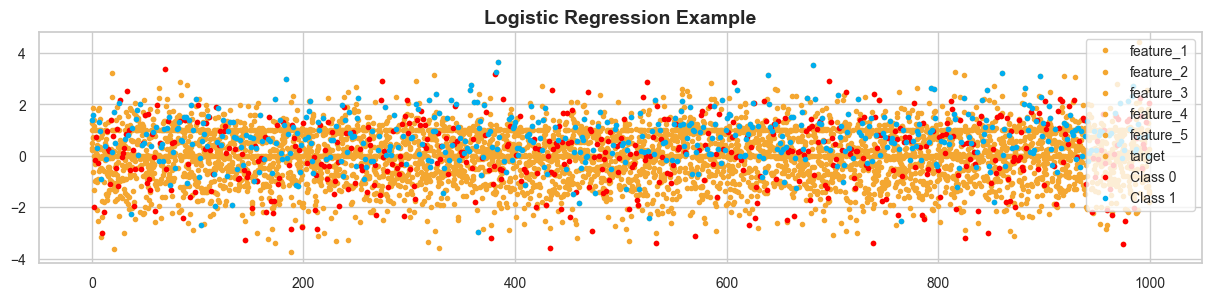

In [5]:
df.plot(style='.',
        figsize=(15, 3),
        color=custom_palette[2],
        title='Logistic Regression Example')

# Plot class 0
df[df['target'] == 0]['feature_1'].plot(
    style='.', color=custom_palette[0], label='Class 0')

# Plot class 1
df[df['target'] == 1]['feature_1'].plot(
    style='.', color=custom_palette[1], label='Class 1')

plt.title('Logistic Regression Example')
plt.legend()
plt.show()

## Scale data

**Models that require scaling**
- **LogisticRegression**: Gradient descent + regularization depend on scale
- **SVM (Support Vector Machine)**: Uses distance & dot products
- **KNN (K-Nearest Neighbors)**: Distance-based
- **PCA, t-SNE, LDA**: Variance-based, sensitive to feature magnitude
- **GradientDescent-based models**: Faster convergence and balanced weights

**No need to scale**
- **DecisionTreeClassifier**: Splits are based on feature thresholds
- **RandomForestClassifier**: Tree-based → not distance-sensitive
- **XGBoost, LightGBM, CatBoost**: Also tree-based, no need for scaling

Note: If features ranges vary widely (e.g. feature_1 is 0–1 and feature_2 is 1000–5000), scale before:
- Regularization
- Distance-based metrics
- Dimensionality reduction

In [6]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df.drop('target', axis=1))

# Create new DataFrame with scaled values and original target
features = df.drop('target', axis=1).columns
df_scaled = pd.DataFrame(X_scaled, columns=features)
df_scaled['target'] = df['target']

In [7]:
# Use df_scaled for further analysis
df = df_scaled.copy()

### Histograms

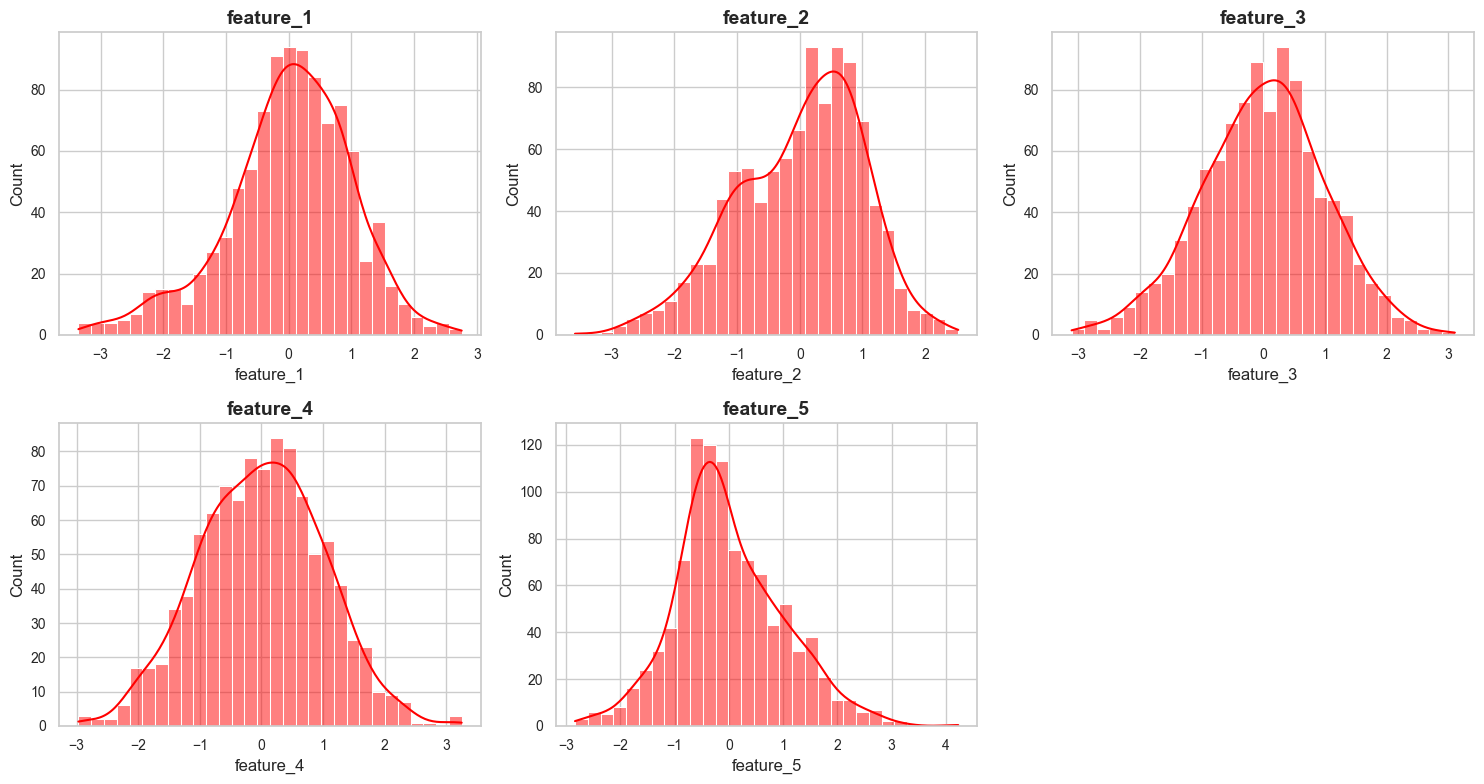

In [8]:
# Plot histograms for train data
features = df.drop('target', axis=1).columns

plt.figure(figsize=(15, 8))
for i, col in enumerate(features, 1):
    plt.subplot(2, 3, i)
    sns.histplot(df[col], bins=30, kde=True)
    plt.title(col)
plt.tight_layout()
plt.show()

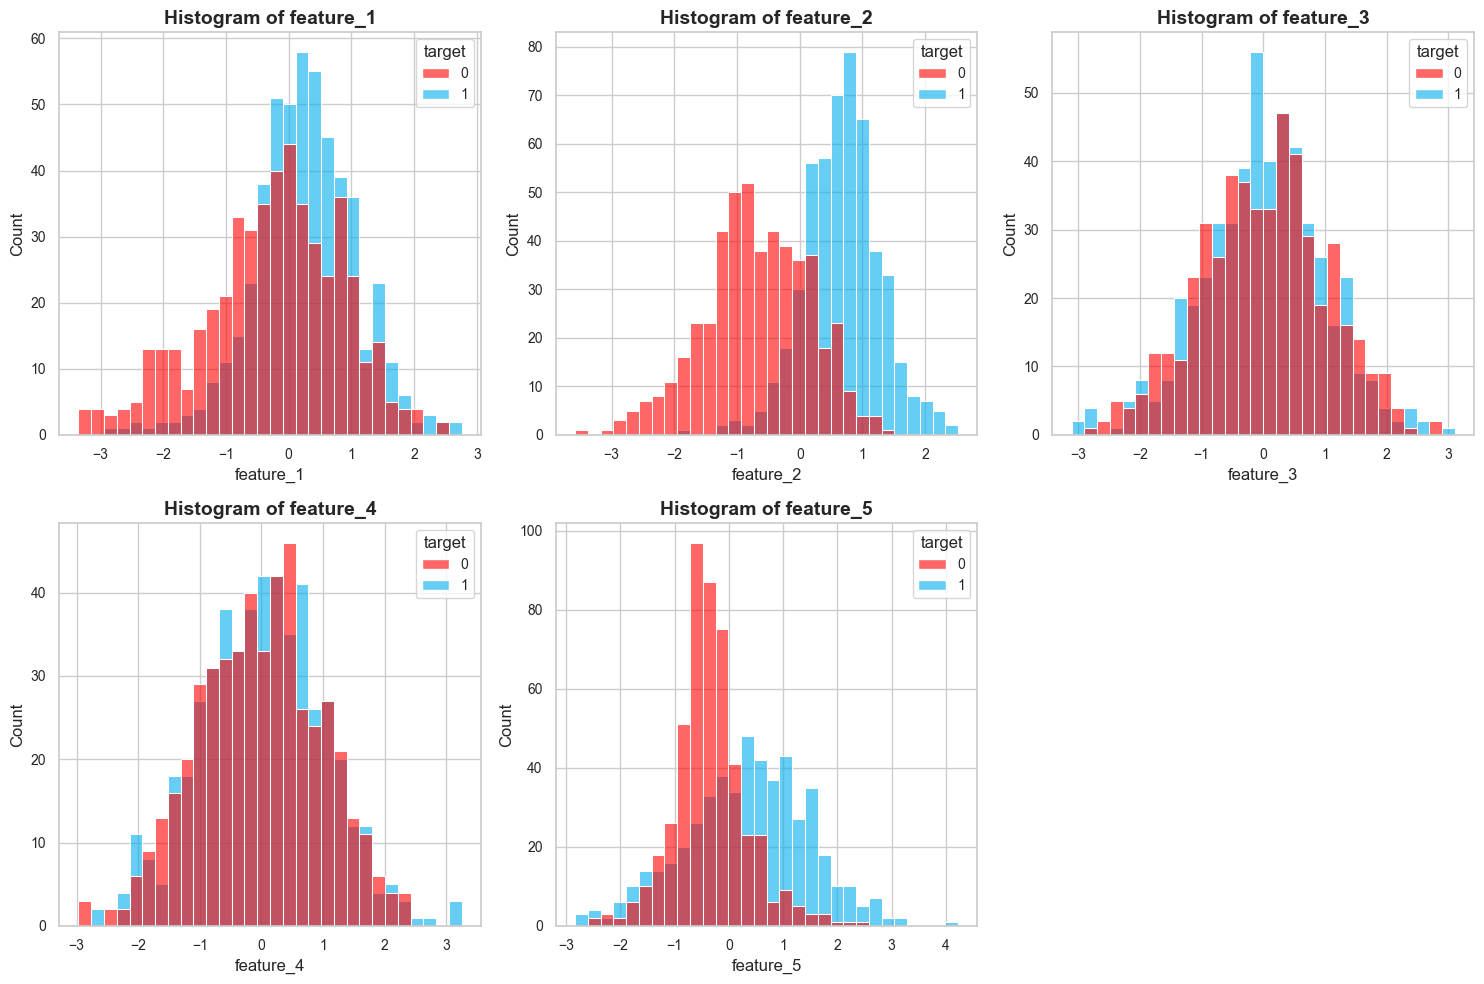

In [9]:
plt.figure(figsize=(15, 10))
for i, col in enumerate(features, 1):
    plt.subplot(2, 3, i)
    sns.histplot(data=df, x=col, hue='target', bins=30, alpha=0.6)
    plt.title(f'Histogram of {col}')
plt.tight_layout()
plt.show()

### Violinplots

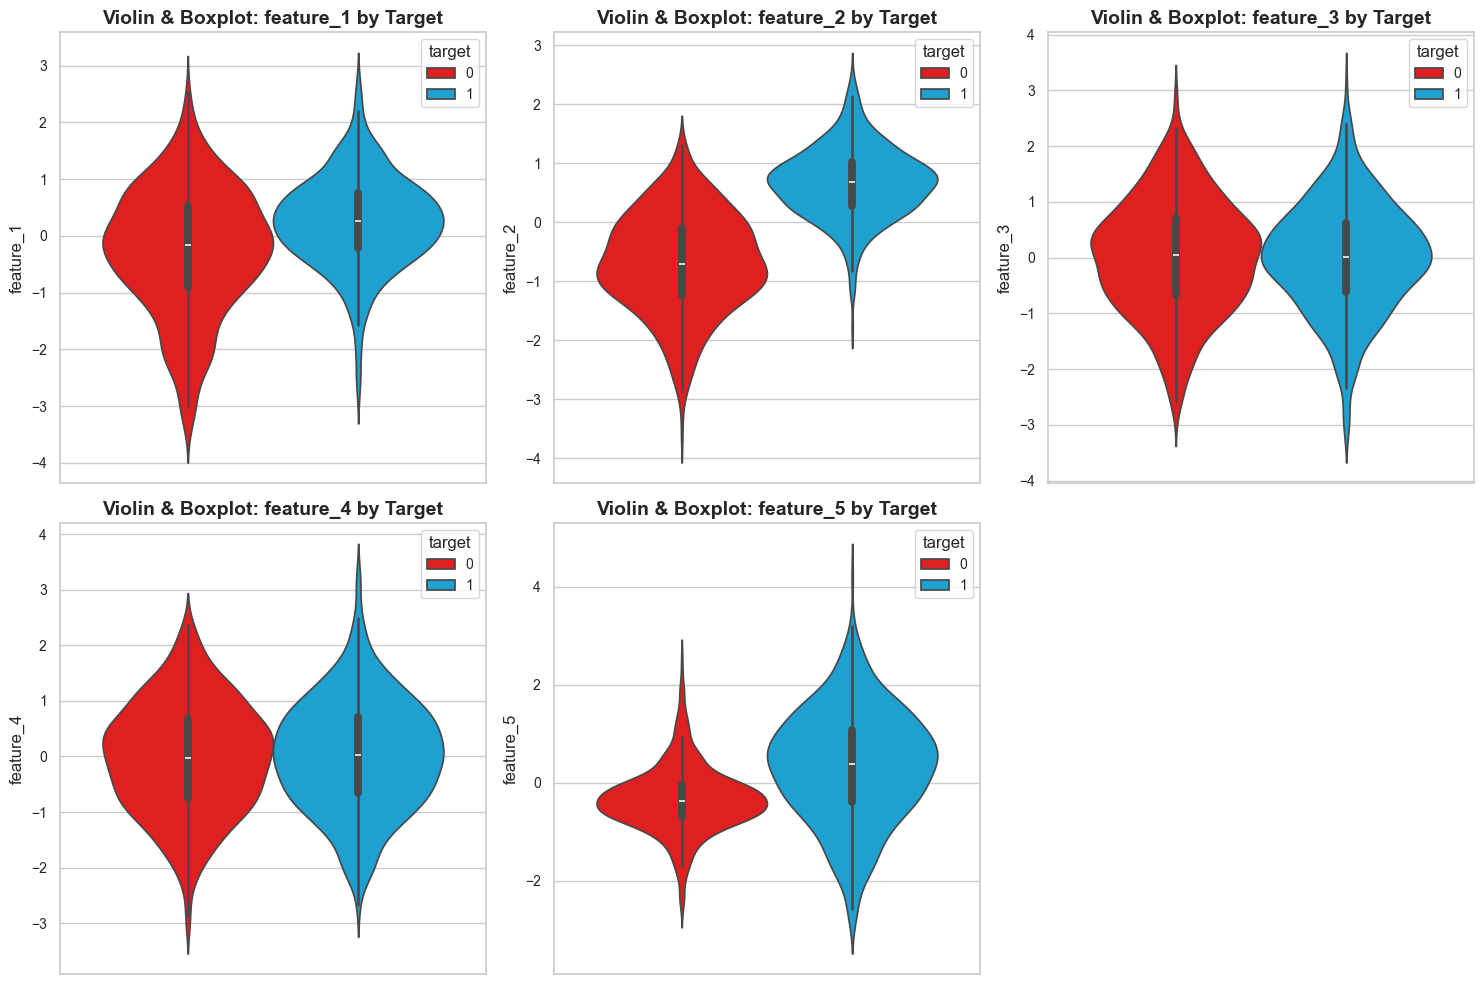

In [10]:
plt.figure(figsize=(15, 10))
for i, col in enumerate(features, 1):
    plt.subplot(2, 3, i)
    sns.violinplot(data=df, hue='target', y=col, inner='box')
    plt.title(f'Violin & Boxplot: {col} by Target')
plt.tight_layout()
plt.show()

### Boxplots

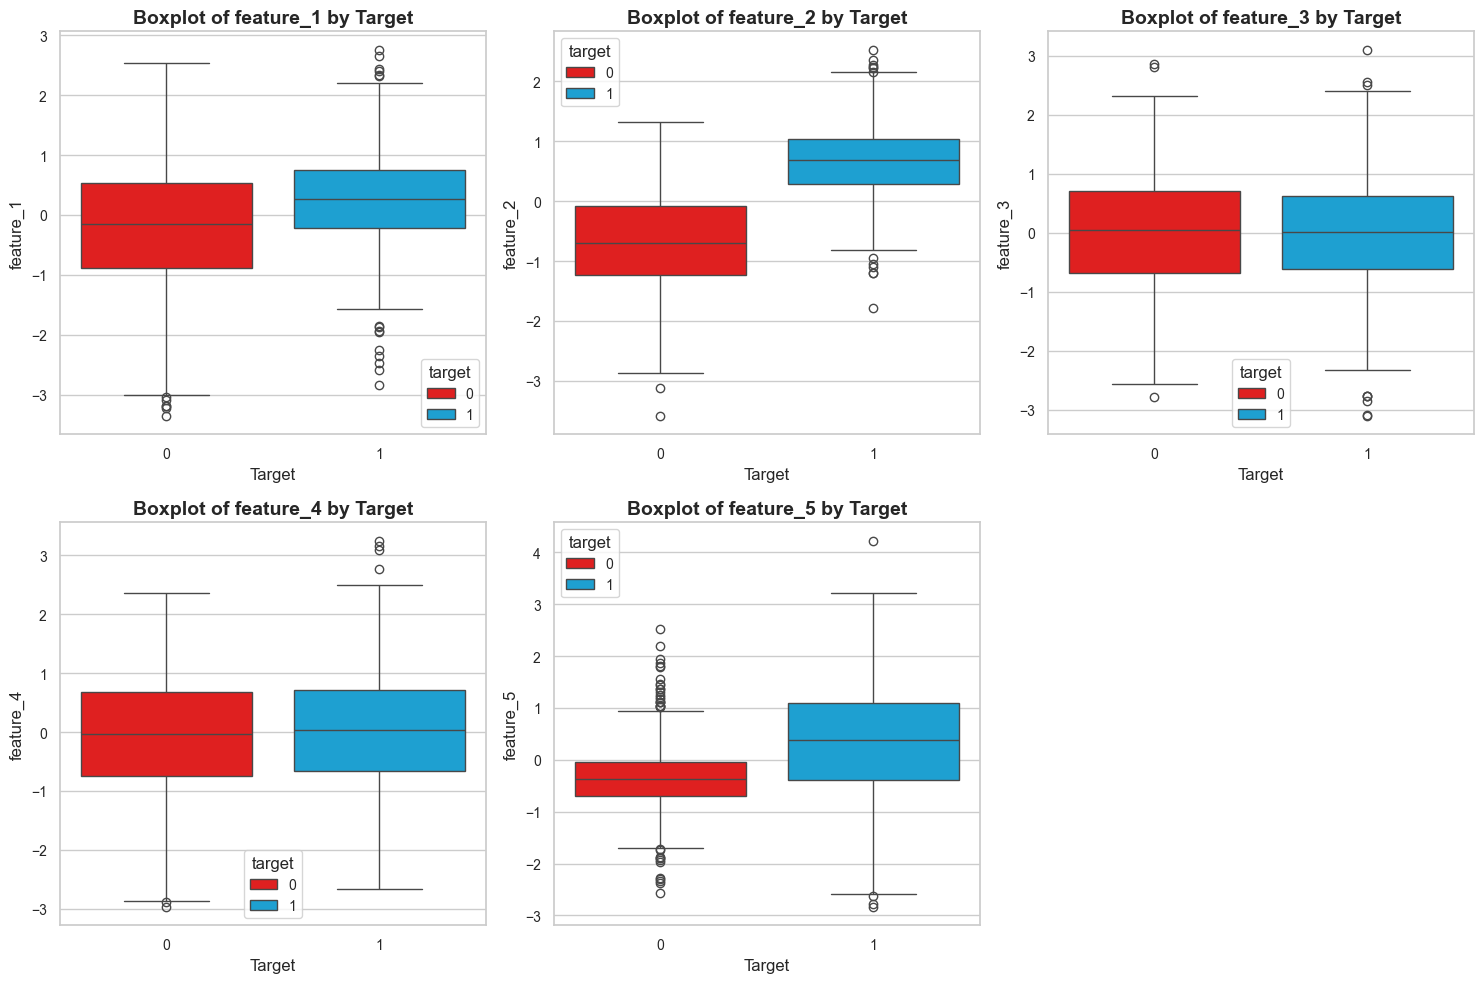

In [11]:
# List of feature column names (excluding the target)
features = df.drop('target', axis=1).columns

# Create boxplots
plt.figure(figsize=(15, 10))
for i, col in enumerate(features, 1):
    plt.subplot(2, 3, i)  # adjust layout based on number of features
    sns.boxplot(data=df, x='target', hue='target', y=col)
    plt.title(f'Boxplot of {col} by Target')
    plt.xlabel('Target')
    plt.ylabel(col)

plt.tight_layout()
plt.show()

## Inspect Outliers

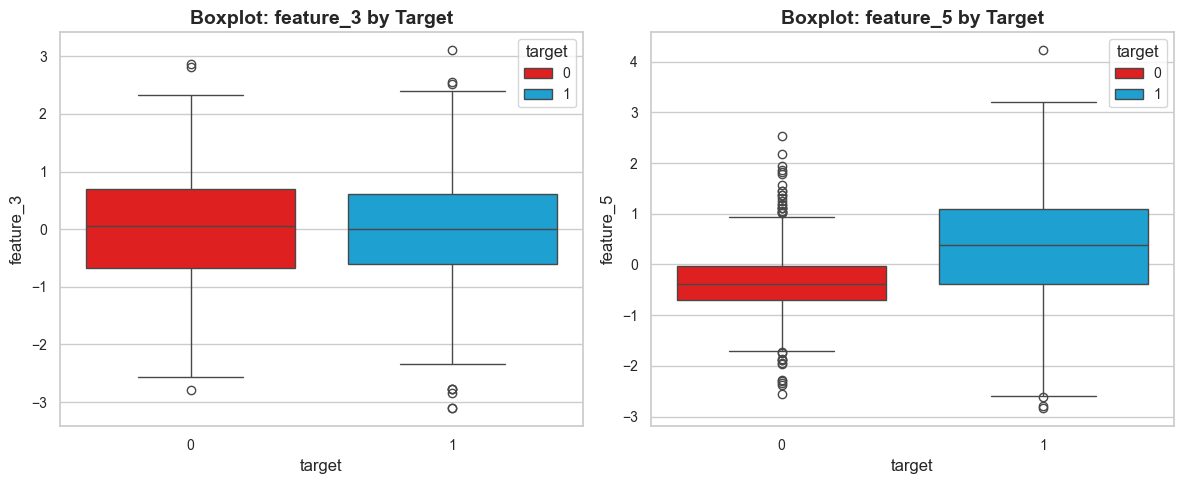

In [12]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.boxplot(data=df, y='feature_3', x='target', hue='target')
plt.title('Boxplot: feature_3 by Target')

plt.subplot(1, 2, 2)
sns.boxplot(data=df, y='feature_5', x='target', hue='target')
plt.title('Boxplot: feature_5 by Target')

plt.tight_layout()
plt.show()

### Removing Outliers or Capping / winsorization

In [13]:
def detect_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR # 1.5 * IQR is a common multiplier for outlier detection
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    return outliers

# Get outliers
outliers_f3 = detect_outliers_iqr(df, 'feature_3')
outliers_f5 = detect_outliers_iqr(df, 'feature_5')


In [14]:
print("Outliers in feature_3:")
print(outliers_f3[['feature_3', 'target']])

print("\nOutliers in feature_5:")
print(outliers_f5[['feature_5', 'target']])

Outliers in feature_3:
     feature_3  target
9    -3.100718       1
83    2.864442       0
170  -2.766743       1
324  -2.847674       1
370  -2.773413       1
459  -3.106920       1
505  -2.771860       1
919   3.105967       1
959  -2.788772       0
969   2.811349       0

Outliers in feature_5:
     feature_5  target
21   -2.835049       1
63    2.665013       1
173  -2.620016       1
231  -2.542366       1
242   2.529107       0
250   2.714463       1
306   2.911491       1
318  -2.583495       1
323   3.094782       1
328  -2.786998       1
425   2.733543       1
508  -2.563251       0
558   2.631098       1
585   2.824227       1
646   2.639298       1
816   3.208702       1
853   2.727703       1
990   4.224828       1
997   2.609153       1


In [15]:
# Option REMOVE: df with outliers removed
# Find indices of outliers
outlier_indices = set(outliers_f3.index).union(outliers_f5.index)

df_removed = df.drop(index=outlier_indices)

In [16]:
# Option CAP: Use capped version to reduce skew
def cap_outliers_iqr(df, column):
    df = df.copy()  # Make a copy first to avoid modifying original
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    df[column] = df[column].clip(lower=lower_bound, upper=upper_bound)
    return df

df_capped = df.copy()

df_capped = cap_outliers_iqr(df_capped, 'feature_3')
df_capped = cap_outliers_iqr(df_capped, 'feature_5')

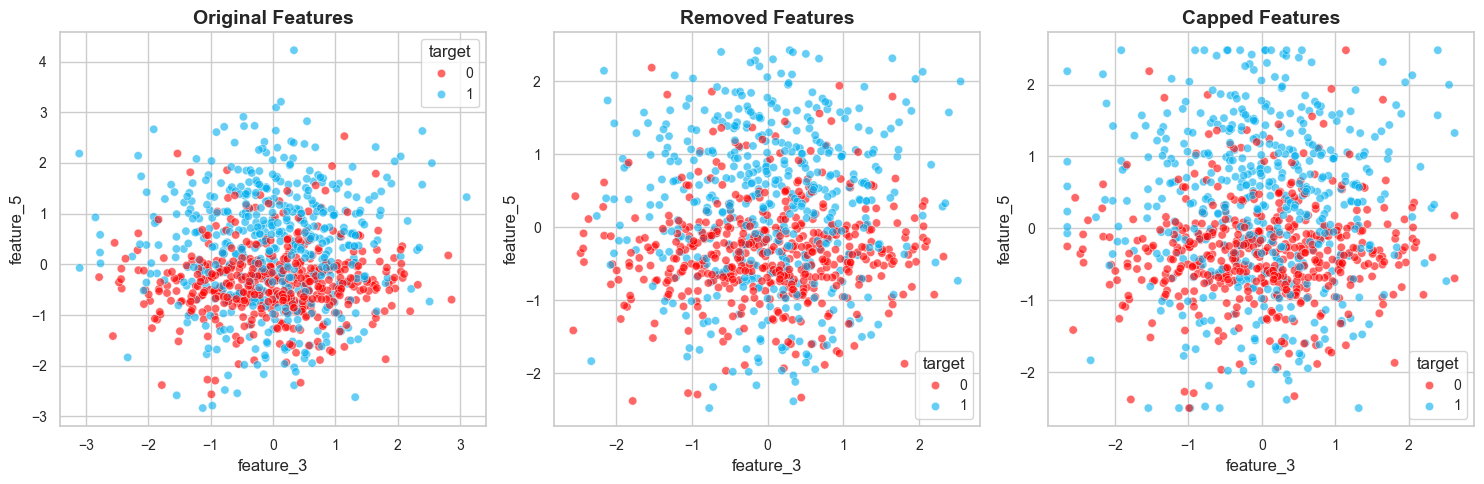

In [17]:
plt.figure(figsize=(15, 5))

# Outliers Removed
plt.subplot(1, 3, 1)
sns.scatterplot(data=df, x='feature_3', y='feature_5', hue='target', alpha=0.6)
plt.title("Original Features")

# Outliers Removed
plt.subplot(1, 3, 2)
sns.scatterplot(data=df_removed, x='feature_3', y='feature_5', hue='target', alpha=0.6)
plt.title("Removed Features")

# Log-transformed
plt.subplot(1, 3, 3)
sns.scatterplot(data=df_capped, x='feature_3', y='feature_5', hue='target', alpha=0.6)
plt.title("Capped Features")

plt.tight_layout()
plt.show()

### Scatterplot

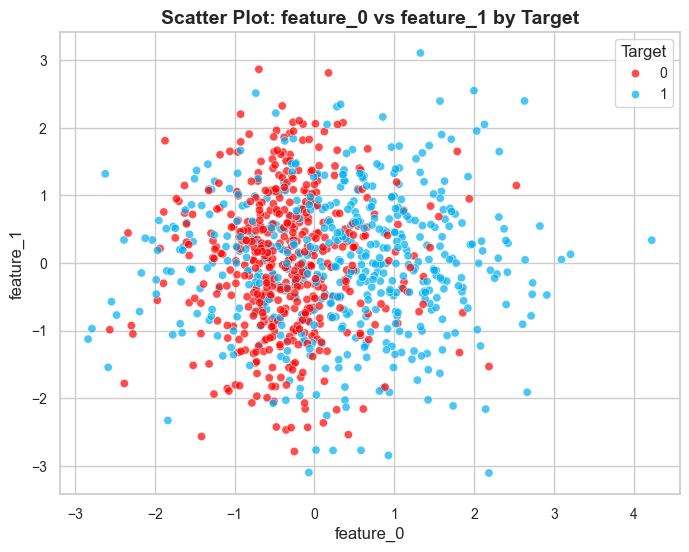

In [18]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_scaled, x='feature_5', y='feature_3', hue='target', alpha=0.7)
plt.title('Scatter Plot: feature_0 vs feature_1 by Target')
plt.xlabel('feature_0')
plt.ylabel('feature_1')
plt.legend(title='Target')
plt.grid(True)
plt.show()

# Step 2: Model Selection & Training

### Train-Test-Split

In [19]:
X = df.drop('target', axis=1)
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Logistic Regression

In [20]:
# Train a logistic regression model
lr = LogisticRegression(C=0.01, max_iter=1000, solver='liblinear')
# lr = LogisticRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

# Evaluate
evaluate_model(y_test=y_test, y_pred=y_pred, title="Logistic Regression")



Logistic Regression Evaluation:
Accuracy score: 0.835
Accuracy [%]: 0.83
              precision    recall  f1-score   support

           0       0.84      0.82      0.83        99
           1       0.83      0.85      0.84       101

    accuracy                           0.83       200
   macro avg       0.84      0.83      0.83       200
weighted avg       0.84      0.83      0.83       200



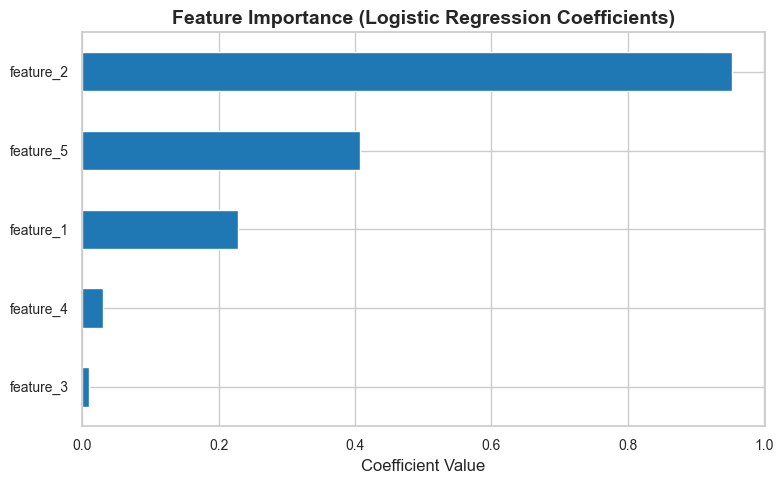

In [21]:
# Check feature importance
# Get coefficients and feature names
coefs = lr.coef_[0]  # for binary classification, .coef_ is shape (1, n_features)
feature_importance = pd.Series(coefs, index=X.columns)

# Sort by absolute importance
feature_importance = feature_importance.sort_values(key=abs, ascending=True)

# Plot
plt.figure(figsize=(8, 5))
feature_importance.plot(kind='barh', color='#1f77b4')
plt.title("Feature Importance (Logistic Regression Coefficients)")
plt.xlabel("Coefficient Value")
plt.grid(True, axis='x')
plt.tight_layout()
plt.show()

### Regularization-Optimization

In [22]:

# Strong regularization
lr_strong = LogisticRegression(C=0.01, penalty='l2', solver='liblinear')
lr_strong.fit(X_train, y_train)

# Moderate regularization
lr_moderate = LogisticRegression(C=1, penalty='l2', solver='liblinear')
lr_moderate.fit(X_train, y_train)

# Weak regularization
lr_weak = LogisticRegression(C=100, penalty='l2', solver='liblinear')
lr_weak.fit(X_train, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,100
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'liblinear'
,max_iter,100
,multi_class,'deprecated'


In [23]:
# Evaluate the model accuracy
for model in [lr, lr_strong, lr_moderate, lr_weak]:
    y_pred = model.predict(X_test)
    print(f"C={model.C}: Accuracy = {accuracy_score(y_test, y_pred):.3f}")

C=0.01: Accuracy = 0.835
C=0.01: Accuracy = 0.835
C=1: Accuracy = 0.845
C=100: Accuracy = 0.845


### GridSearchCV-Optimization

In [24]:
# Define the parameter grid
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear']  # 'liblinear' supports both l1 and l2
}

# Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=lr,
    param_grid=param_grid,
    cv=5,  # 5-fold cross-validation
    scoring='accuracy',
    n_jobs=-1  # use all CPU cores
)

# Run grid search
grid_search.fit(X_train, y_train)

,estimator,LogisticRegre...r='liblinear')
,param_grid,"{'C': [0.01, 0.1, ...], 'penalty': ['l1', 'l2'], 'solver': ['liblinear']}"
,scoring,'accuracy'
,n_jobs,-1
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,penalty,'l2'


In [25]:
print("Best Parameters:", grid_search.best_params_)
print(f"Best Cross-Validated Accuracy: {grid_search.best_score_:.3f}")

Best Parameters: {'C': 0.01, 'penalty': 'l2', 'solver': 'liblinear'}
Best Cross-Validated Accuracy: 0.855


# Step 3: Find alternative model(s)
Trying more powerful classifiers
- RandomForestClassifier
- GradientBoostingClassifie or XGBoost
- SVC (Support Vector Classifier)
- KNeighborsClassifier

## Random Forest Classifier

In [26]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# No need to scale!
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

# Predict
y_pred_rf = rf.predict(X_test)

# Evaluate
evaluate_model(y_test=y_test, y_pred=y_pred_rf, title="Random Forest")


Random Forest Evaluation:
Accuracy score: 0.915
Accuracy [%]: 0.92
              precision    recall  f1-score   support

           0       0.93      0.90      0.91        99
           1       0.90      0.93      0.92       101

    accuracy                           0.92       200
   macro avg       0.92      0.91      0.91       200
weighted avg       0.92      0.92      0.91       200



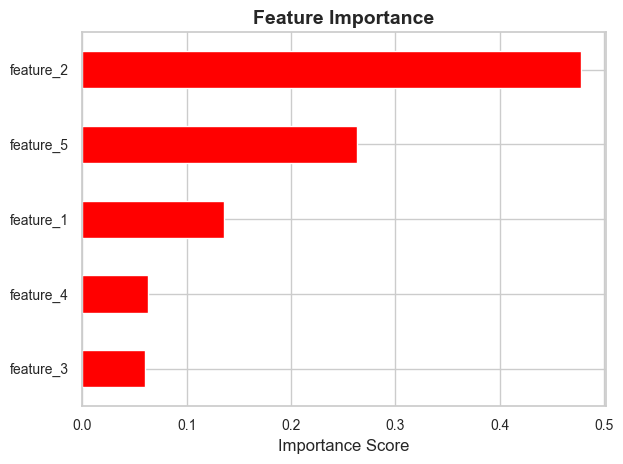

In [27]:
# visualize feature importances
feature_importance = pd.Series(rf.feature_importances_, index=X.columns)
feature_importance.sort_values().plot(kind='barh', title="Feature Importance")
plt.xlabel("Importance Score")
plt.tight_layout()
plt.show()

In [28]:
# Hyperparameter tuning for Random Forest
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
}

grid_rf = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)

grid_rf.fit(X_train, y_train)

print("Best Parameters:", grid_rf.best_params_)
print(f"Best Cross-Validated Accuracy: {grid_rf.best_score_:.3f}")

# Evaluate on test data
y_pred_best_rf = grid_rf.best_estimator_.predict(X_test)
print("Tuned Random Forest Accuracy:", evaluate_model(y_test, y_pred_best_rf))

Best Parameters: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}
Best Cross-Validated Accuracy: 0.900

None Evaluation:
Accuracy score: 0.92
Accuracy [%]: 0.92
              precision    recall  f1-score   support

           0       0.94      0.90      0.92        99
           1       0.90      0.94      0.92       101

    accuracy                           0.92       200
   macro avg       0.92      0.92      0.92       200
weighted avg       0.92      0.92      0.92       200

Tuned Random Forest Accuracy: None


## XGBoost Classifier

In [42]:
from xgboost import XGBClassifier

xgb = XGBClassifier(eval_metric='logloss', random_state=42)
xgb.fit(X_train, y_train)

y_pred_xgb = xgb.predict(X_test)

print(evaluate_model(y_test, y_pred_xgb, title="XGBoost"))


XGBoost Evaluation:
Accuracy score: 0.875
Accuracy [%]: 0.88
              precision    recall  f1-score   support

           0       0.89      0.85      0.87        99
           1       0.86      0.90      0.88       101

    accuracy                           0.88       200
   macro avg       0.88      0.87      0.87       200
weighted avg       0.88      0.88      0.87       200

None


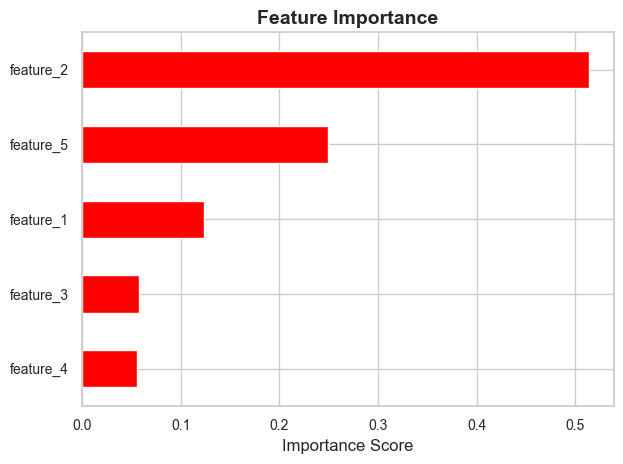

In [45]:
# visualize feature importances
importances = xgb.feature_importances_
feature_importance = pd.Series(importances, index=X.columns)
feature_importance.sort_values().plot(kind='barh', title="Feature Importance")
plt.xlabel("Importance Score")
plt.tight_layout()
plt.show()

# Step 4: Evaluation

## Confusion Matrix

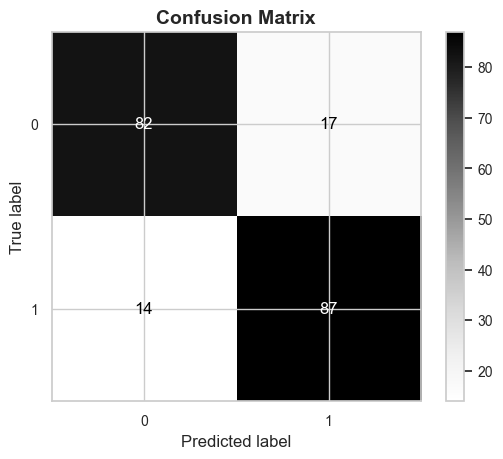

In [29]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=lr.classes_)
disp.plot(cmap='Grays')
plt.title("Confusion Matrix")
plt.show()

In [30]:
# Show feature correlation with target
corr = pd.concat([X, y], axis=1).corr()
print(corr['target'].sort_values(ascending=False))

target       1.000000
feature_2    0.682577
feature_5    0.340014
feature_1    0.254769
feature_4    0.021664
feature_3   -0.000267
Name: target, dtype: float64


## ROC Curve (Receiver Operating Characteristic)

Shows the tradeoff between:
- True Positive Rate (TPR) = Sensitivity, Recall
- False Positive Rate (FPR) = 1 - Specificity

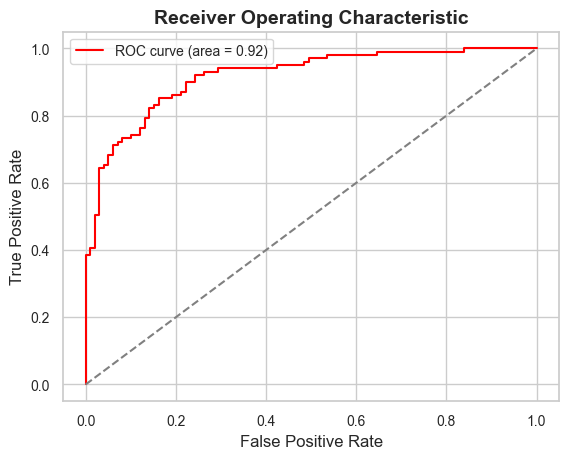

In [31]:
y_proba = lr.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend()
plt.show()

## Visualizing Predictions / False Predictions

In [32]:
plot_df = X_test.copy()
plot_df['Actual'] = y_test.values
plot_df['Predicted'] = y_pred
plot_df['Correct'] = plot_df['Predicted'] == plot_df['Actual'] # mark the correct predictions

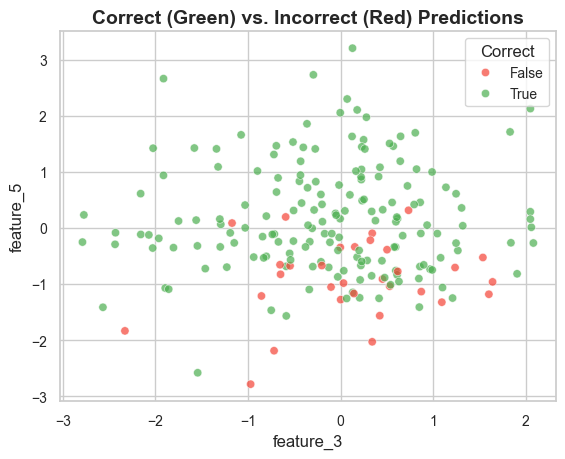

In [33]:
# Green for correct, red for wrong
correct_palette = {True: '#4CAF50', False: '#F44336'}  # or use 'green'/'red'
sns.scatterplot(
    data=plot_df,
    x='feature_3',
    y='feature_5',
    hue='Correct',
    palette=correct_palette,
    alpha=0.7
)
plt.title("Correct (Green) vs. Incorrect (Red) Predictions")
plt.show()

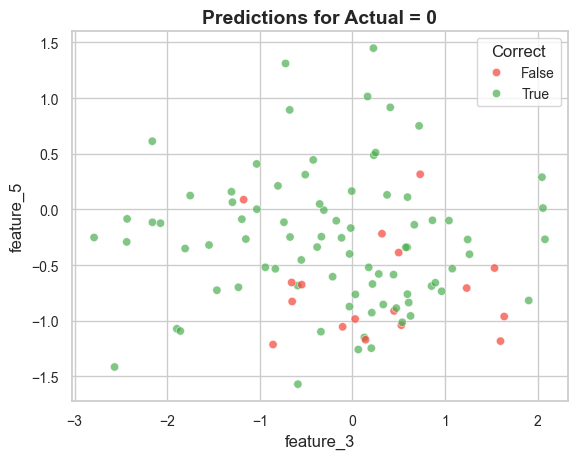

In [34]:
# Just Actual = 0
sns.scatterplot(
    data=plot_df[plot_df['Actual'] == 0],
    x='feature_3',
    y='feature_5',
    hue='Correct',
    palette=correct_palette,
    alpha=0.7
)
plt.title("Predictions for Actual = 0")
plt.show()

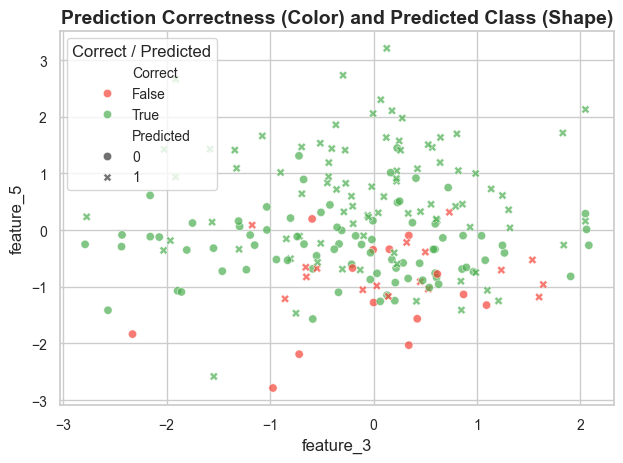

In [35]:
# 1. Add prediction metadata
plot_df = X_test.copy()
plot_df['Actual'] = y_test.values
plot_df['Predicted'] = y_pred
plot_df['Correct'] = plot_df['Predicted'] == plot_df['Actual']

# 2. Define custom color palette for correctness
correct_palette = {True: '#4CAF50', False: '#F44336'}  # Green and Red

# 3. Plot with color by Correct, and marker style by Predicted class
sns.scatterplot(
    data=plot_df,
    x='feature_3',
    y='feature_5',
    hue='Correct',             # Green/Red
    style='Predicted',         # Shape by class 0 or 1
    palette=correct_palette,
    alpha=0.7
)

plt.title("Prediction Correctness (Color) and Predicted Class (Shape)")
plt.legend(title='Correct / Predicted')
plt.tight_layout()
plt.show()

# Step 5: Result

In [36]:
result = plot_df.copy()
result = result[['feature_3', 'Predicted']]
result.head()

,feature_3,Predicted
521,0.030721,1
737,-0.363969,1
740,0.177314,0
660,0.222716,1
411,0.844268,1
